In [0]:
!ls

sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/M.Tech Project

/content/drive/My Drive/M.Tech Project


In [0]:
!ls

drive  sample_data


In [0]:
cd VGG Semantic

/content/drive/My Drive/M.Tech Project/VGG Semantic


0016E5_05070.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


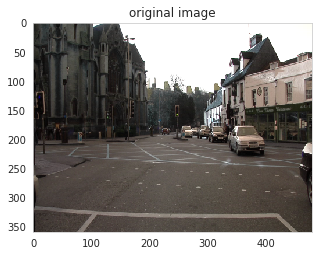

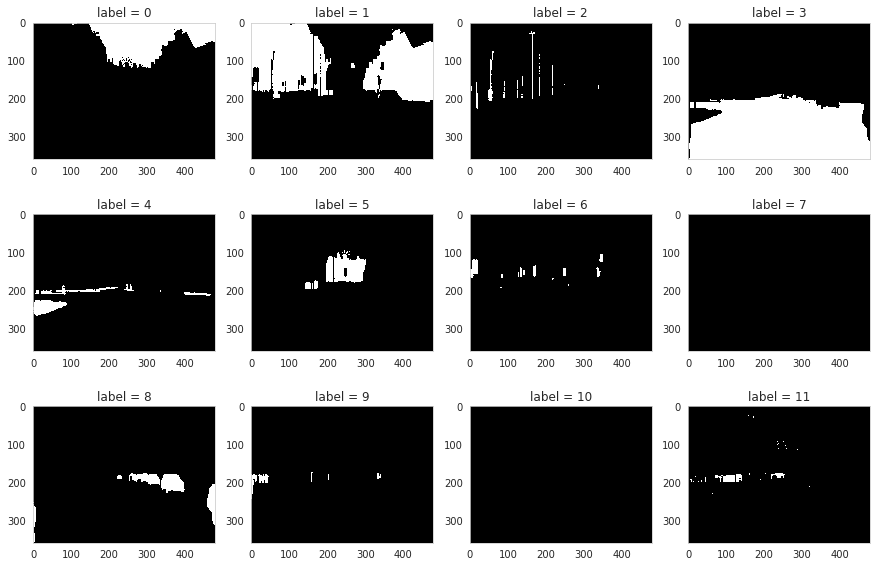

In [0]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
from keras import optimizers



dir_data = "dataset/"
dir_seg = dir_data + "train_label/"
dir_img = dir_data + "/train_data/"


sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))


fnm = ldseg[0]
print(fnm)






seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)

img_is = cv2.imread(dir_img + fnm )





print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))



mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


plt.show()







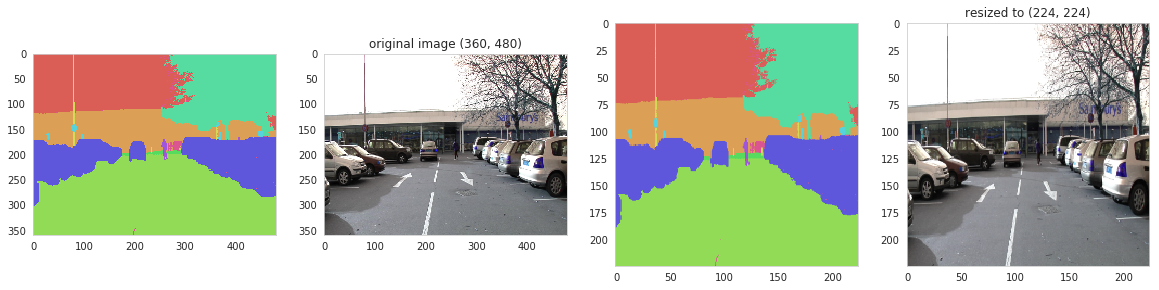

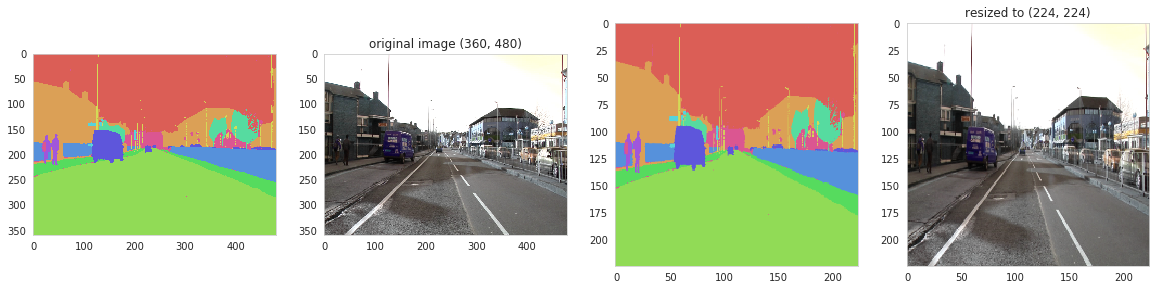

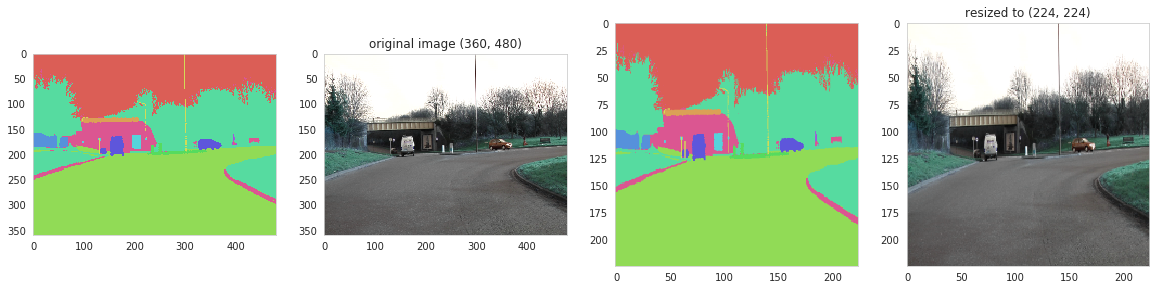

In [0]:

#-------Data preprocessing: Resize image and Adding colors to image-----------------

def give_color_to_seg_img(seg, n_classes):

    if len(seg.shape) == 3:
        seg = seg[:, :, 0]
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3)).astype('float')
    colors = sns.color_palette("hls", n_classes)
   
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:, :, 0] += (segc * (colors[c][0]))
        seg_img[:, :, 1] += (segc * (colors[c][1]))
        seg_img[:, :, 2] += (segc * (colors[c][2]))

    return (seg_img)


input_height, input_width = 224, 224
output_height, output_width = 224, 224

ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg), 3, replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png")  # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg, n_classes)

    fig = plt.figure(figsize=(20, 40))
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(seg_img)

    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(img_is / 255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))

    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(cv2.resize(seg_img, (input_height, input_width)))

    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(cv2.resize(img_is, (output_height, output_width)) / 255.0)
    ax.set_title("resized to {}".format((output_height, output_width)))
    plt.show()


In [0]:

#--------------Resizing All images----------------------

def getImageArr(path, width, height):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)

    return seg_labels


images = os.listdir(dir_img)
images.sort()
segmentations = os.listdir(dir_seg)
segmentations.sort()

X = []
Y = []
for im, seg in zip(images, segmentations):
    X.append(getImageArr(dir_img + im, input_width, input_height))
    Y.append(getSegmentationArr(dir_seg + seg, n_classes, output_width, output_height))

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)



(367, 224, 224, 3) (367, 224, 224, 12)


In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd
from keras.applications.vgg16 import VGG16
import h5py


In [0]:

VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


def FCN8(nClasses, input_height=224, input_width=224):
    
    assert input_height % 32 == 0
    assert input_width % 32 == 0
    IMAGE_ORDERING = "channels_last"

    img_input = Input(shape=(input_height, input_width, 3))  ## Assume 224,224,3

    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING)(x)
    f1 = x

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING)(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING)(
        x)  

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING)(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING)(x)  


    vgg = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path)   

    n = 4096
    o = (Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)

    conv7 = (Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)

    
    conv7_4 = Conv2DTranspose(nClasses, kernel_size=(4, 4), strides=(4, 4), use_bias=False, data_format=IMAGE_ORDERING)(
        conv7)
    
   
    pool411 = (
        Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (
        Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), use_bias=False, data_format=IMAGE_ORDERING))(
        pool411)

    pool311 = (
        Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)

    o = Add(name="add")([pool411_2, pool311, conv7_4])
    o = Conv2DTranspose(nClasses, kernel_size=(8, 8), strides=(8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
    o = (Activation('softmax'))(o)

    model = Model(img_input, o)

    return model


model = FCN8(nClasses=n_classes, input_height=224, input_width=224)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________________

In [0]:

#-------------------------------Split between training and testing data---------------------------



train_rate = 0.85
index_train = np.random.choice(X.shape[0], int(X.shape[0] * train_rate), replace=False)
index_test = list(set(range(X.shape[0])) - set(index_train))

X, Y = shuffle(X, Y)
X_train, y_train = X[index_train], Y[index_train]
X_test, y_test = X[index_test], Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [0]:
#------------------------Training------------------------


sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=300,verbose=2)



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 311 samples, validate on 56 samples
Epoch 1/300
 - 35s - loss: 2.6273 - acc: 0.0822 - val_loss: 2.4839 - val_acc: 0.0916
Epoch 2/300
 - 11s - loss: 2.4828 - acc: 0.0947 - val_loss: 2.4813 - val_acc: 0.0977
Epoch 3/300
 - 11s - loss: 2.4796 - acc: 0.0998 - val_loss: 2.4767 - val_acc: 0.1051
Epoch 4/300
 - 11s - loss: 2.4727 - acc: 0.1116 - val_loss: 2.4656 - val_acc: 0.1192
Epoch 5/300
 - 12s - loss: 2.4544 - acc: 0.1298 - val_loss: 2.4327 - val_acc: 0.1471
Epoch 6/300
 - 12s - loss: 2.3942 - acc: 0.1645 - val_loss: 2.4559 - val_acc: 0.1404
Epoch 7/300
 - 12s - loss: 2.2938 - acc: 0.2214 - val_loss: 2.0879 - val_acc: 0.3092
Epoch 8/300
 - 12s - loss: 2.0905 - acc: 0.3269 - val_loss: 1.9373 - val_acc: 0.3397
Epoch 9/300
 - 12s - loss: 1.9420 - acc: 0.3392 - val_loss: 2.2436 - val_acc: 0.3475
Epoch 10/300
 - 12s - loss: 1.9185 - acc: 0.3454 - val_loss: 1.8

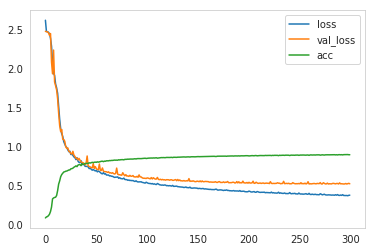

(56, 224, 224) (56, 224, 224)


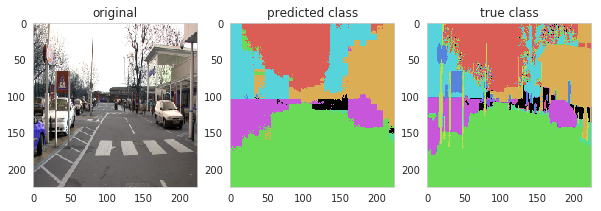

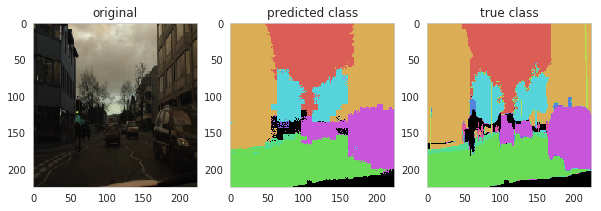

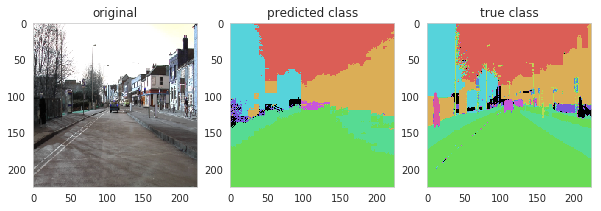

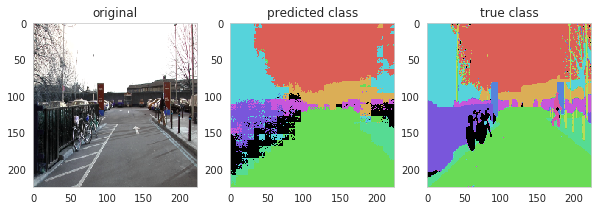

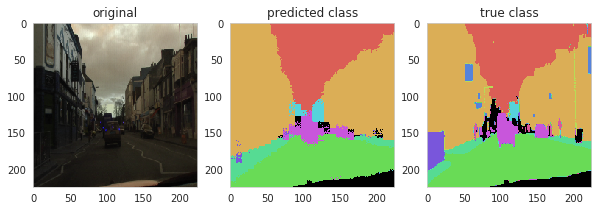

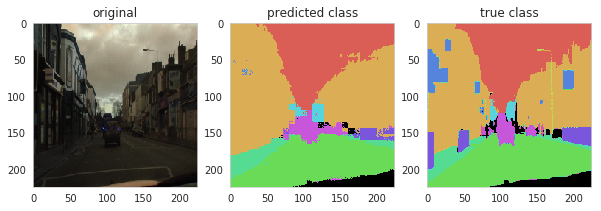

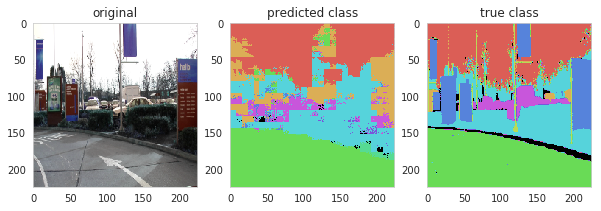

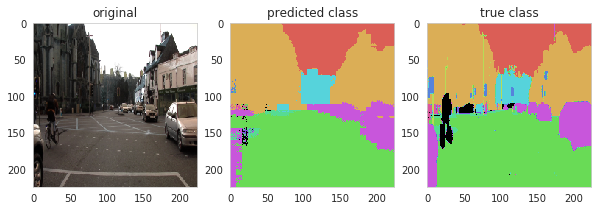

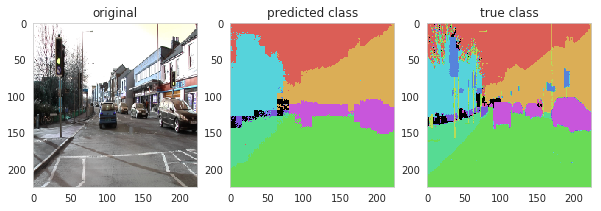

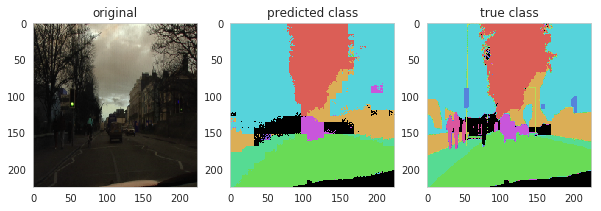

In [0]:
for key in ['loss', 'val_loss', 'acc']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()


#-----------------------------------------------


y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

#---------------------------------Visualize the model performance-----------------------

shape = (224, 224)
n_classes = 10

for i in range(10):
    img_is = (X_test[i] + 1) * (255.0 / 2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10, 30))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(img_is / 255.0)
    ax.set_title("original")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(give_color_to_seg_img(seg, n_classes))
    ax.set_title("predicted class")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(give_color_to_seg_img(segtest, n_classes))
    ax.set_title("true class")
    plt.show()

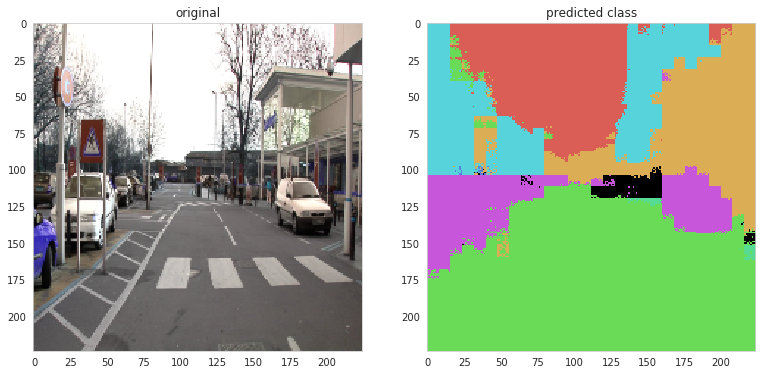

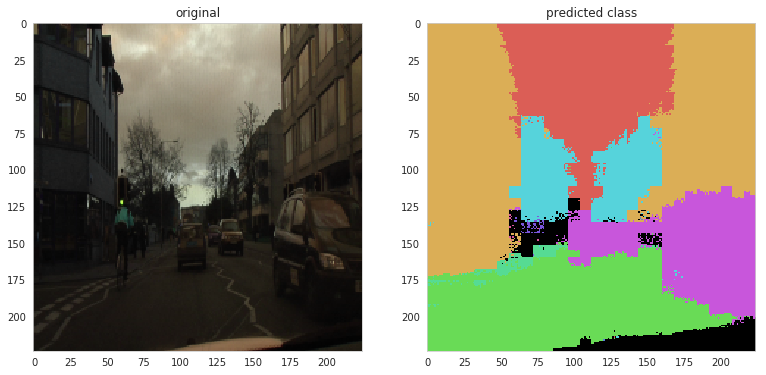

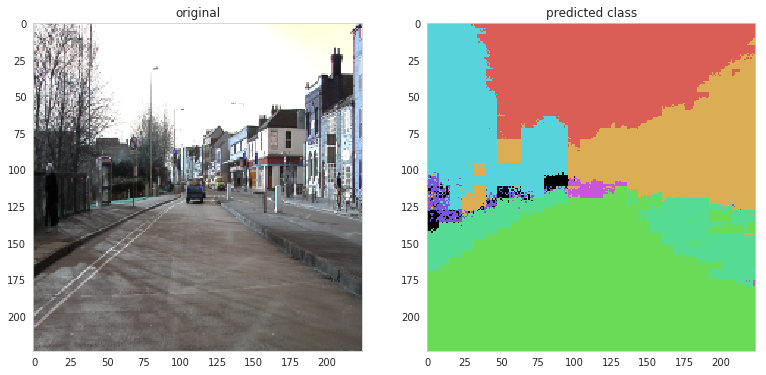

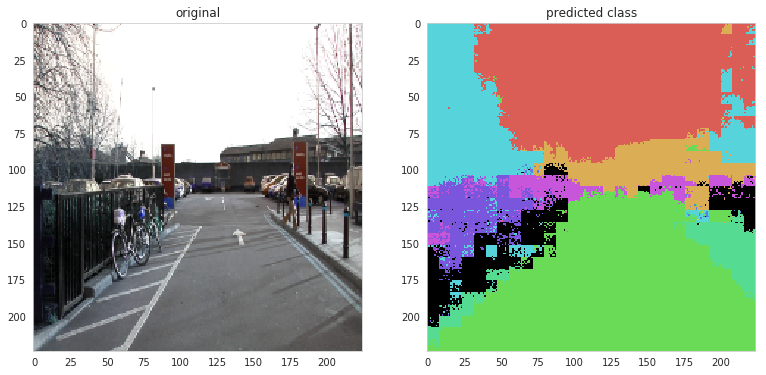

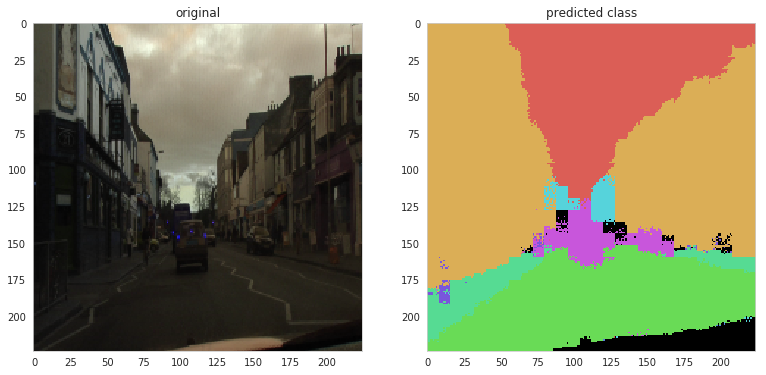

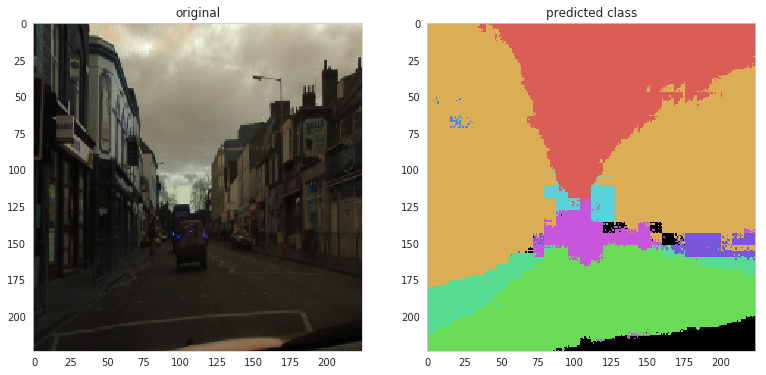

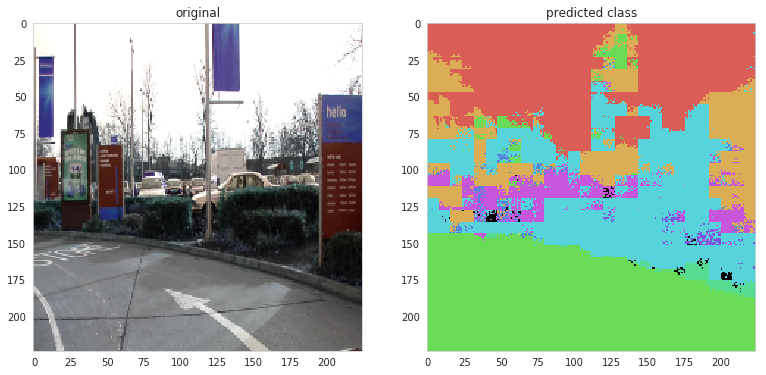

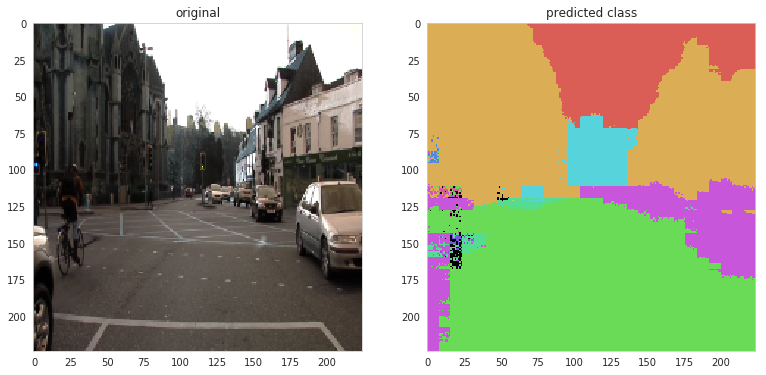

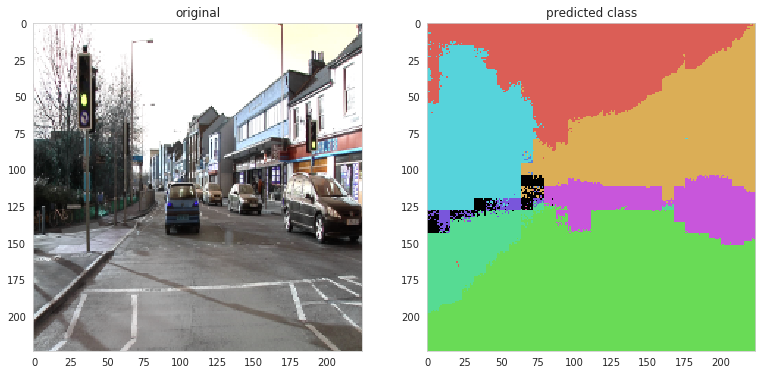

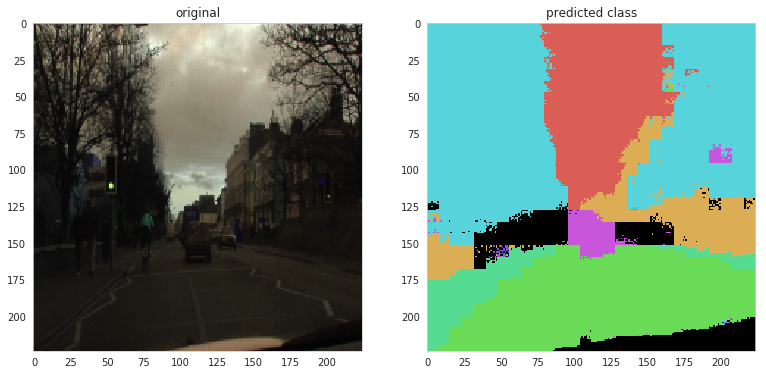

In [0]:
shape = (224, 224)
n_classes = 10

for i in range(10):
    img_is = (X_test[i] + 1) * (255.0 / 2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20, 40))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(img_is / 255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(give_color_to_seg_img(seg, n_classes))
    ax.set_title("predicted class")


    plt.show()

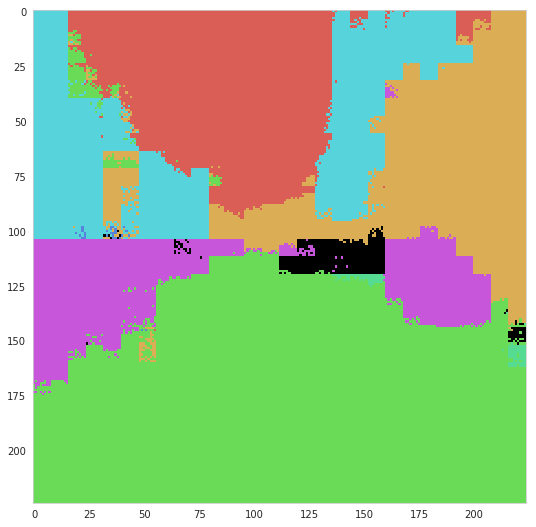

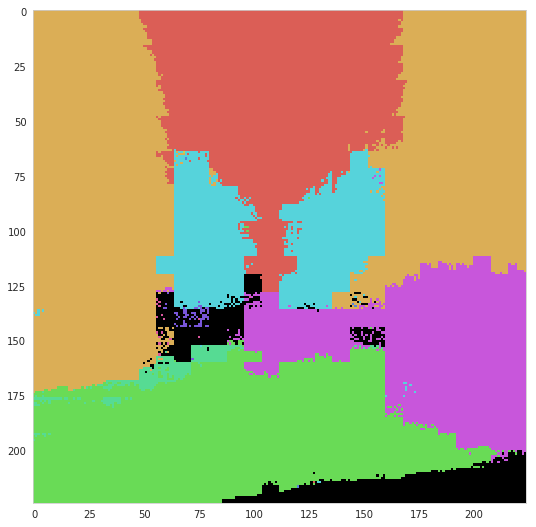

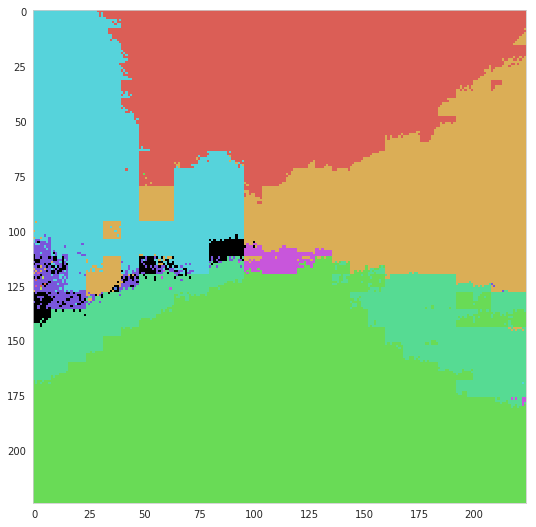

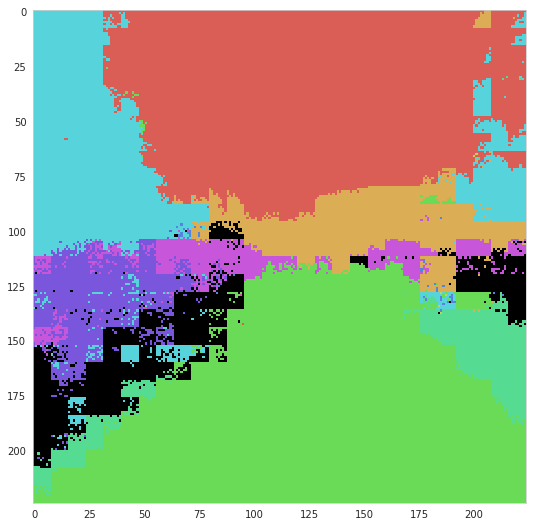

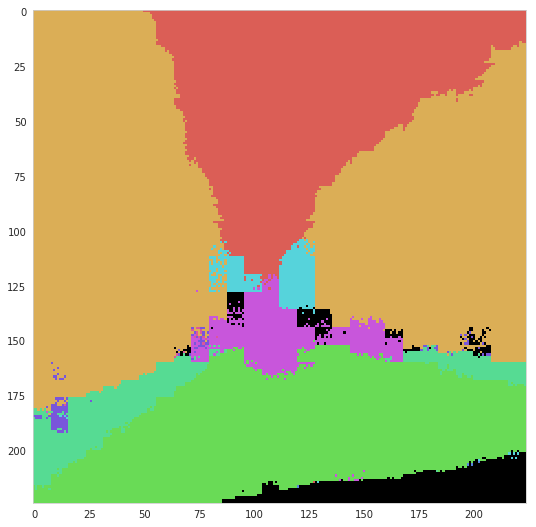

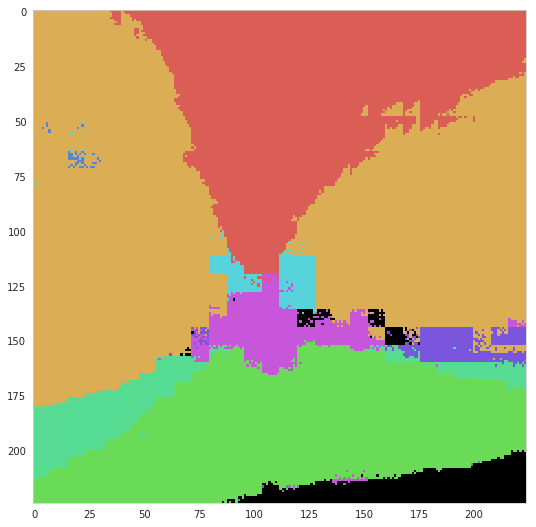

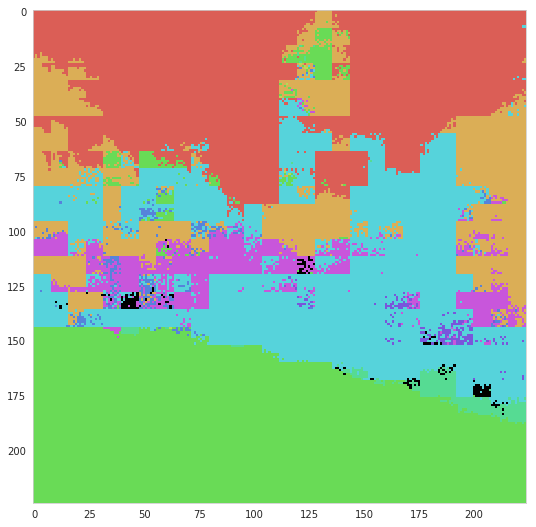

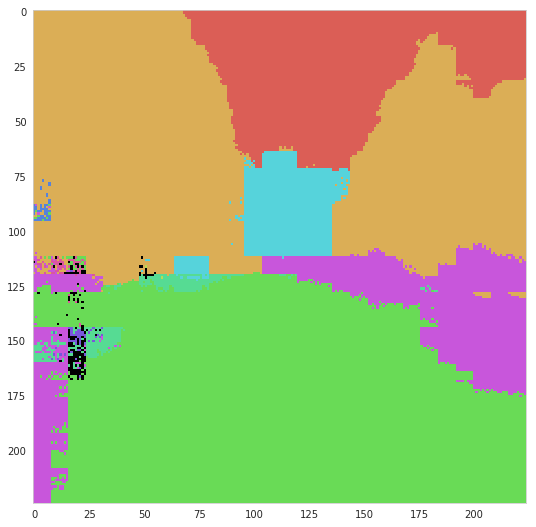

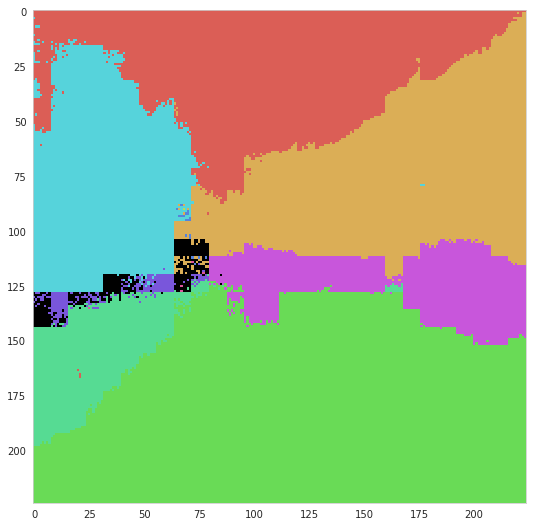

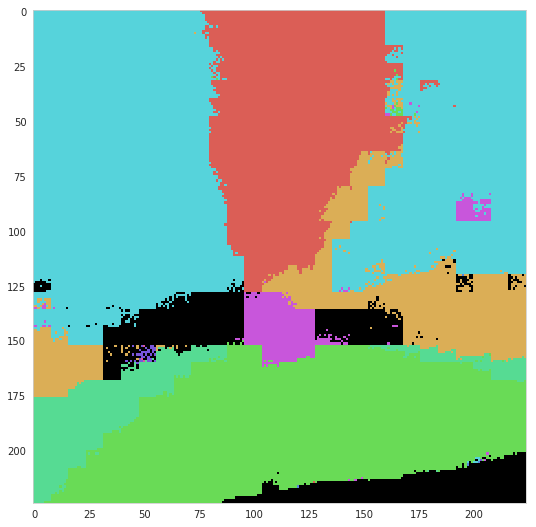

In [0]:
shape = (224, 224)
n_classes = 10

for i in range(10):
    img_is = (X_test[i] + 1) * (255.0 / 2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(30, 50))
    #ax = fig.add_subplot(1, 3, 1)
    #ax.imshow(img_is / 255.0)
    #ax.set_title("original")
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(give_color_to_seg_img(seg, n_classes))
    #ax.set_title("predicted class")


    plt.show()

In [0]:
def IoU(Yi,y_predi):
 

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=459078, #FP= 37012, #FN=34846, IoU=0.865
class 01: #TP=552442, #FP=132140, #FN=47184, IoU=0.755
class 02: #TP=    16, #FP=   104, #FN=35745, IoU=0.000
class 03: #TP=860244, #FP= 36647, #FN=38889, IoU=0.919
class 04: #TP= 89878, #FP= 24659, #FN=41591, IoU=0.576
class 05: #TP=228222, #FP= 83288, #FN=44413, IoU=0.641
class 06: #TP=   598, #FP=  1533, #FN=49255, IoU=0.012
class 07: #TP= 13314, #FP= 12562, #FN=25505, IoU=0.259
class 08: #TP=161436, #FP= 44888, #FN=31907, IoU=0.678
class 09: #TP=   266, #FP=   734, #FN=23014, IoU=0.011
class 10: #TP=   195, #FP=   577, #FN= 9098, IoU=0.020
class 11: #TP= 28838, #FP= 41185, #FN=33882, IoU=0.278
_________________
Mean IoU: 0.418
